#  Erdbebenlokalisierung mit Triangulation
Erdbebenwellen breiten sich vom Erdbebenherd in alle Richtungen aus und werden von seismischen Stationen an der Oberfläche registriert. Um den Ort des Erdbebens zu bestimmen, nutzen Seismologen P-Wellen (Primärwellen), da sie die schnellsten seismischen Wellen sind und somit als erstes an den Stationen ankommen. S-Wellen können ebenso benutzt werden, aufgrund ihrer langsamereren Geschwindigkeit dauert jedoch länger bis diese aufgezeichnet werden.

Die Triangulation ist eine einfache Methode zur Bestimmung des Erdbebenepizentrums. Dabei werden die Ankunftszeiten der P-Wellen (und/oder S-Wellen) an mehreren Stationen (Seismometern) verglichen. Mittels der Laufzeiten der seismischen Wellen kann die Entfernung jeder Station zum Erdbeben berechnen. Zeichnet man um jede Station einen Kreis mit diesem Abstand, ergibt der Schnittpunkt der Kreise die ungefähre Lage des Epizentrums.

In dieser Aufgabe betrachten wir 5 Erdbeben, und lokalisieren sie jeweils mittels 3 Stationen.

In [2]:
# Importe
import matplotlib.pyplot as plt
import numpy as np
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import cartopy
import matplotlib.pyplot as plt
from ipywidgets import FloatSlider, FloatText, HBox, Label, interactive_output, Output
from IPython.display import display
import matplotlib.patches as patches  

from seismology_utils import get_data, plot_with_start_slider, plot_with_p_s, get_station_info


# START AUFGABE
Wähle nacheinander Erdbeben 1-5 und lokalisiere mittels Triangulation. Die Herdzeit ist gegeben.

# Part 1: Erdbeben Lokalisierung mit P-Welle und Herdzeit

In [4]:
# Wähle Erdbeben 1,2,3,4, oder 4
earthquake_number = 2

if earthquake_number==1: 
    # Beben 1
    origin_time = UTCDateTime("2025-07-21T10:52:16")   # start time
    station_data = [
        {"network": "CH", "station": "SFRS", "channel":"HGZ"},
        {"network": "CH", "station": "SINS", "channel":"HGZ"},
        {"network": "CH", "station": "FIESA", "channel":"HHZ"},
    ]
elif earthquake_number==2: # geht nicht
    # Beben 2
    origin_time = UTCDateTime("2025-07-21T19:17:25")   
    station_data = [
        {"network": "CH", "station": "VANNI", "channel":"HHZ"},
        {"network": "CH", "station": "LKBD2", "channel":"HHZ"},
        {"network": "CH", "station": "EMBD", "channel":"HHZ"},
    ]
elif earthquake_number==3:
    # Beben 3
    origin_time = UTCDateTime("2025-07-13T12:16:29")   # start time
    station_data = [
        {"network": "CH", "station": "SGRA", "channel":"HGZ"},
        {"network": "CH", "station": "MMK", "channel":"HHZ"},
        {"network": "CH", "station": "FIESA", "channel":"HHZ"},
    ]
elif earthquake_number==4:
    # Beben 4
    origin_time = UTCDateTime("2025-07-28T13:48:21")   # start time
    station_data = [
        {"network": "CH", "station": "SRFW", "channel":"HGZ"},
        {"network": "CH", "station": "SRHB", "channel":"HGZ"},
        {"network": "CH", "station": "SULZ", "channel":"HHZ"},
    ]

elif earthquake_number==5:
    # Beben 5
    origin_time = UTCDateTime("2025-07-29T13:03:12")   # start time
    station_data = [
        {"network": "CH", "station": "SENIN", "channel":"HHZ"},
        {"network": "CH", "station": "GRYON", "channel":"HHZ"},
        {"network": "CH", "station": "STSW2", "channel":"HGZ"},
    ]
else:
    print("Wähle Erdbeben 1,2,3,4, oder 5")


station_info = get_station_info(station_data,origin_time)

### Seismogramme herunterladen, prozessieren, und überprüfen

In [5]:
# Daten Download der vertikal Komponente
st1, st2, st3 = get_data(station_data,origin_time)

print("Seismogramme in Streams enthalten") 
print("mit Network/Station/Channel Code; sowie Start und Ende des Seismograms; Abtastfrequenz [Hz], und Anzahl Zeitschritte in Zeitreihe")
print(st1)
print(st2)
print(st3)

Seismogramme in Streams enthalten
mit Network/Station/Channel Code; sowie Start und Ende des Seismograms; Abtastfrequenz [Hz], und Anzahl Zeitschritte in Zeitreihe
1 Trace(s) in Stream:
CH.VANNI..HHZ | 2025-07-21T19:17:25.000000Z - 2025-07-21T19:17:45.000000Z | 200.0 Hz, 4001 samples
1 Trace(s) in Stream:
CH.LKBD2..HHZ | 2025-07-21T19:17:25.000000Z - 2025-07-21T19:17:45.000000Z | 200.0 Hz, 4001 samples
1 Trace(s) in Stream:
CH.EMBD..HHZ | 2025-07-21T19:17:25.000000Z - 2025-07-21T19:17:45.000000Z | 200.0 Hz, 4001 samples


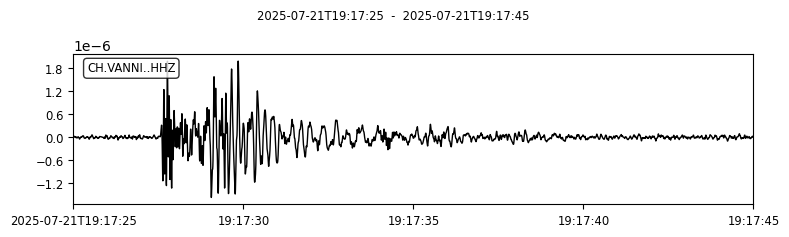

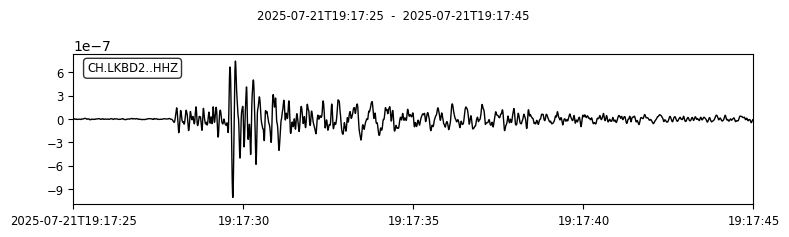

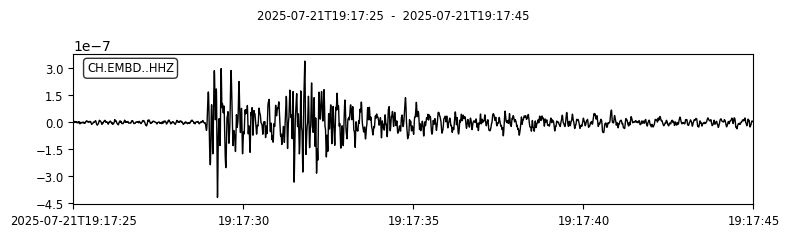

In [6]:
# Daten Plotten, die Einheit ist m/s (Bodenbewegung)
plt.close("all")
%matplotlib inline

st1.plot()
st2.plot()
st3.plot();

### Wähle für jede Aufzeichnung die Startzeit des Erdbebensignals (Beginn der P-Welle, da diese die schnellste Welle ist).

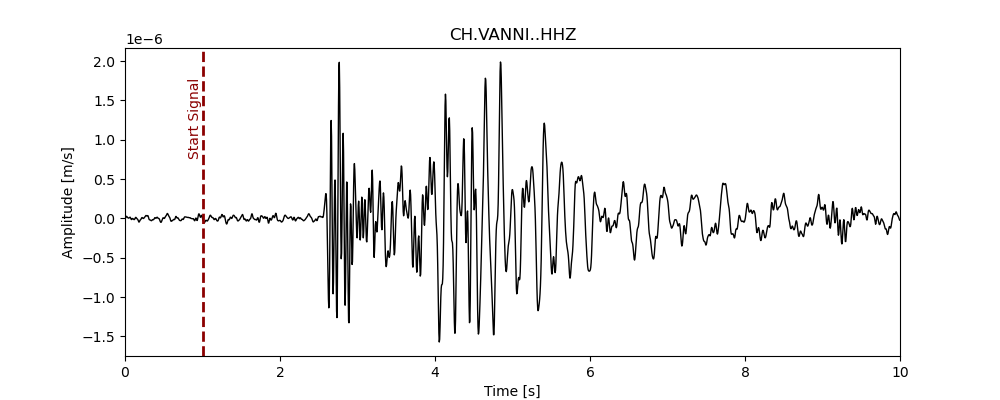

In [7]:
# Bestimme Start des Erdbebensignals an Station 1
%matplotlib widget

start_station1 = 1 # 
# Ändere Länge des Seismograms im Plot mittels time_range = [0,10] in Sekunden
selected_start_station1 = plot_with_start_slider(st1[0],initial_start=start_station1,time_range=[0,10])

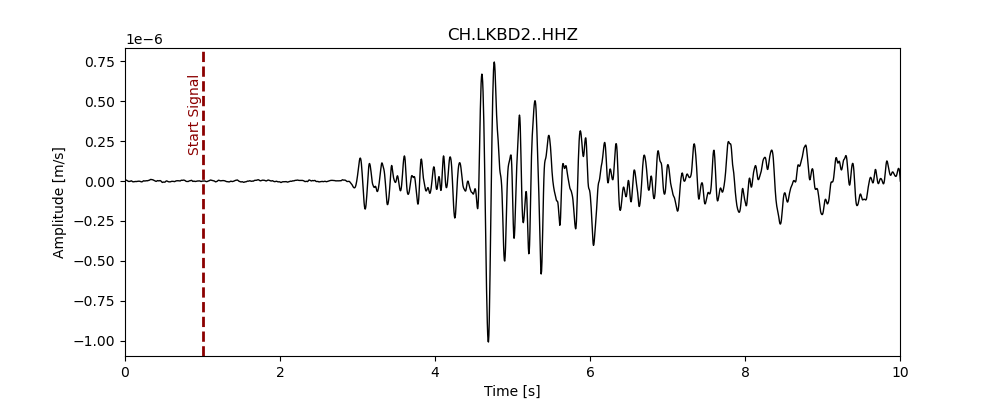

In [8]:
# Bestimme Start des Erdbebensignals an Station 2
%matplotlib widget

start_station2 = 1
selected_start_station2 = plot_with_start_slider(st2[0],initial_start=start_station2,time_range=[0,10])

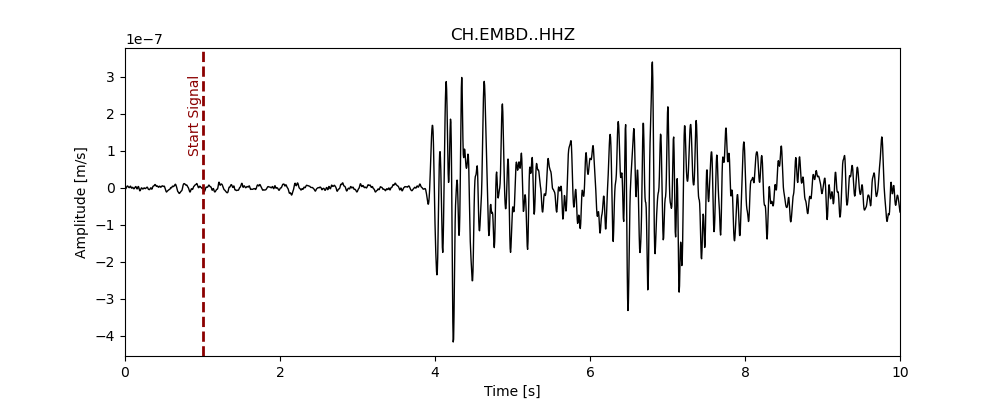

In [9]:
# Bestimme Start des Erdbebensignals an Station 3
%matplotlib widget

start_station3 = 1
selected_start_station3 = plot_with_start_slider(st3[0],initial_start=start_station3,time_range=[0,10])

In [10]:
start_station1 = selected_start_station1["start"]
start_station2 = selected_start_station2["start"]
start_station3 = selected_start_station3["start"]

print("Gewählte Laufzeiten (Station 1,2,3)")
print(station_data[0]["station"] + f": {start_station1:.1f} [s]")
print(station_data[1]["station"] + f": {start_station2:.1f} [s]")
print(station_data[2]["station"] + f": {start_station3:.1f} [s]")

Gewählte Laufzeiten (Station 1,2,3)
VANNI: 2.5 [s]
LKBD2: 2.9 [s]
EMBD: 3.8 [s]


In [13]:
# Bestimme Distanzen
# Hinweis: die angegebene Zeit ist relativ zur Herdzeit des Bebens
vp = ... # TODO Nutze typische P Wellengeschwindigkeit in [km/s]; 
vp = 4.5

# Denke daran dass die Geschwindigkeit auch mit der lokalen Geologie variiert.
# Beachte auch, dass Erdbebenwellen mit grösserer Distanz typischer Weise durch tiefere, schneller Schichten propagieren
distance_station1 = ... # TODO Berechen Distanzen
distance_station2 = ... 
distance_station3 = ...

distance_station1 = vp * start_station1
distance_station2 = vp * start_station2
distance_station3 = vp * start_station3

print(f"Geschätzte Distanz von Station 1 [km]: {distance_station1:.1f}")
print(f"Geschätzte Distanz von Station 2 [km]: {distance_station2:.1f}")
print(f"Geschätzte Distanz von Station 3 [km]: {distance_station3:.1f}")

distances_km = [distance_station1, distance_station2, distance_station3]

Geschätzte Distanz von Station 1 [km]: 11.0
Geschätzte Distanz von Station 2 [km]: 12.8
Geschätzte Distanz von Station 3 [km]: 17.1


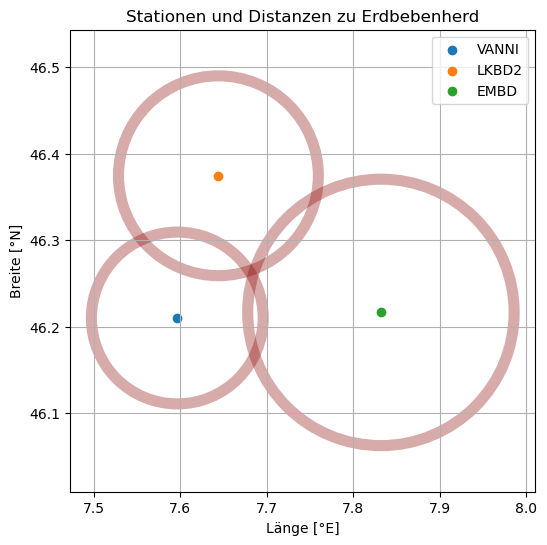

In [16]:

# Schliesse interaktive Plots
plt.close('all')
%matplotlib inline

def km_to_deg(km):
    # Sehr stark vereinfachte Umrechnung von Kilometer zu Grad
    # berücksichtigt nicht, dass 1° Längengrad je nach Breite kürzer wird (≈ 111 km × cos φ und die Erde keine perfekter Kugel ist).
    return km/111
    
fig, ax = plt.subplots(figsize=(6,6))

for i, stat in enumerate(station_info):
    ax.scatter(stat[2], stat[1], label=stat[0])

    distance = distances_km[i]
    circle = patches.Circle((stat[2], stat[1]), radius=km_to_deg(distance), color='darkred', fill=False, lw=8,alpha=0.33)
    ax.add_patch(circle)

ax.axis('equal')
ax.legend()
ax.set_xlabel("Länge [°E]")
ax.set_ylabel("Breite [°N]")
ax.set_title("Stationen und Distanzen zu Erdbebenherd")
ax.grid()
plt.show()

# Tatsächlich ergeben die Distanzen auf der Karte keine sondern Ellipsen (hier stark vereinfacht).

Fragen zur Aufgabe:
1. Kann jedes der Beispiele gleich gut lokalisiert werden? Wenn nein, was sind die Gründe?
2. Die Triangulation ist eine sehr vereinfachte Methode zur Lokalisierung der Erdbebenepizentren. Welche Faktoren werden hierbei nicht beachtet?
3. In dieser Übung war die Herdzeit gegeben und die Laufzeit der Wellen vom Erdbebenherd zur Station können direkt bestimmt werden. Wie könnte das Beben lokalisiert werden wenn die Herdzeit nicht bekannt ist?


In [17]:
# Lösung
# Beben 1: 46.540 N 7.859 E
# Beben 2: 46.277 N 7.639 E
# Beben 3: 46.192 N 7.903 E
# Beben 4: 47.618 7.824 E - schwieriger aufgrund Geometrie der Stationen
# Beben 5: 46.299 N 7.269 E - schwierig da hohes Rauschen

# Part 2: Erdbeben Lokalisierung mit P und S-Welle, ohne Herdzeit

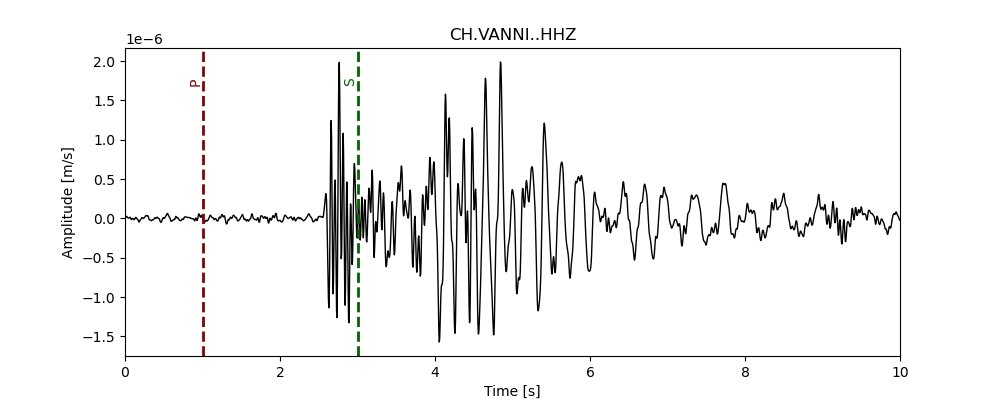

In [18]:
%matplotlib widget
# Station 1, bestimme P und S Einsätze
selected_p_s_station1 = plot_with_p_s(st1[0], initial_p=1, initial_s=3, time_range=[0, 10])


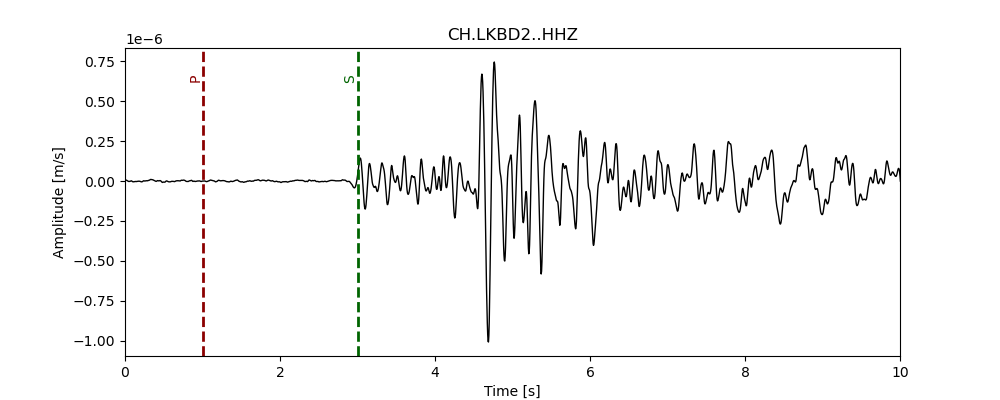

In [19]:
%matplotlib widget
# Station 2, bestimme P und S Einsätze
selected_p_s_station2 = plot_with_p_s(st2[0], initial_p=1, initial_s=3, time_range=[0, 10])


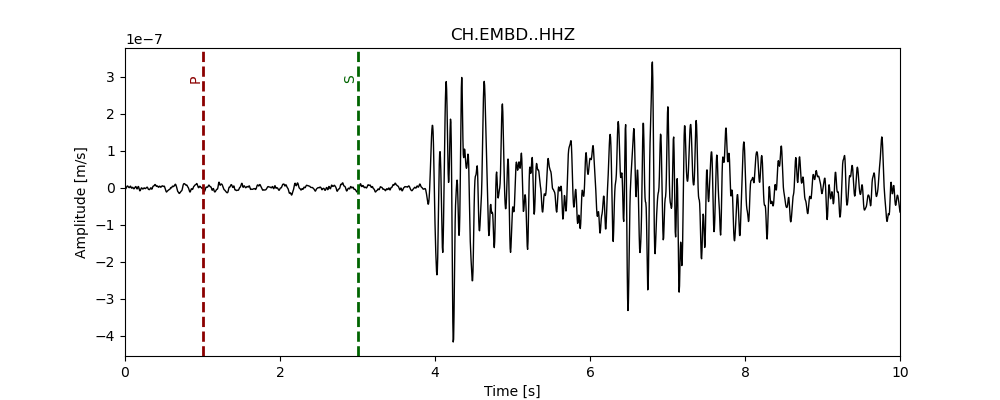

In [30]:
%matplotlib widget
# Station 3, bestimme P und S Einsätze
selected_p_s_station3 = plot_with_p_s(st3[0], initial_p=1, initial_s=3, time_range=[0, 10])

## Bestimme Distanzen mittels P und S Wellen Einsätzen

In [31]:
# Bestimme Distanzen
# Hinweis: die angegebene Zeit ist relativ zur Herdzeit des Bebens
vp = 4.5 # Nutze typische P Wellengeschwindigkeit in [km/s];
vs = vp/1.73 # Nutze typische S Wellengeschwindigkeit in [km/s];


def get_distance(p,s,vp,vs):
    # TODO: Berechne Distanz mit P und S Welleneinsätzen, und P und S Wellen Geschwindigkeit
    distance = ...
    return distance

# Lösung
def get_distance(p,s,vp,vs):
    return (s-p) * (vp*vs) / (vp-vs)
    
# Denke daran dass die Geschwindigkeit auch mit der lokalen Geologie variiert.
# Beachte auch, dass Erdbebenwellen mit grösserer Distanz typischer Weise durch tiefere, schneller Schichten propagieren
distance_station1 = get_distance(selected_p_s_station1["P"],selected_p_s_station1["S"],vp,vs)
distance_station2 = get_distance(selected_p_s_station1["P"],selected_p_s_station2["S"],vp,vs)
distance_station3 = get_distance(selected_p_s_station1["P"],selected_p_s_station3["S"],vp,vs)

print(f"Geschätzte Distanz von Station 1 [km]: {distance_station1:.1f}")
print(f"Geschätzte Distanz von Station 2 [km]: {distance_station2:.1f}")
print(f"Geschätzte Distanz von Station 3 [km]: {distance_station3:.1f}")

Geschätzte Distanz von Station 1 [km]: 8.4
Geschätzte Distanz von Station 2 [km]: 12.3
Geschätzte Distanz von Station 3 [km]: 21.3


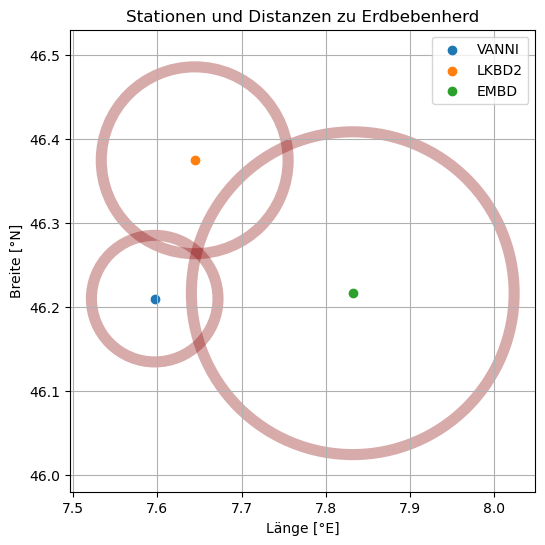

In [32]:
def km_to_deg(kilometer):  
    # stark vereinfachte Umwandlung zur groben Abschätzung
    return kilometer / 111 
    
# Schliesse interaktive Plots
plt.close('all')
%matplotlib inline


fig, ax = plt.subplots(figsize=(6,6))

for i, stat in enumerate(station_info):
    ax.scatter(stat[2], stat[1], label=stat[0])

    distance = [distance_station1, distance_station2, distance_station3][i]
    circle = patches.Circle((stat[2], stat[1]), radius=km_to_deg(distance), color='darkred', fill=False, lw=8,alpha=0.33)
    ax.add_patch(circle)

ax.axis('equal')
ax.legend()
ax.set_xlabel("Länge [°E]")
ax.set_ylabel("Breite [°N]")
ax.set_title("Stationen und Distanzen zu Erdbebenherd")
ax.grid()
plt.show()

## Bestimmung die Herdzeit mit Wadati-Diagram


In [ ]:
# In diesem Beispiel starten die Seismogramme ab der Herdzeit (t=0), daher kennen wir die Herdzeit bereits
# Überprüfe ob deine gewählten P und S Wellen Einsätze die korrekte Herdzeit ergeben, erstelle dazu ein Wadati-Diagram
# Trage die Laufzeitdifferenz von P und S Wellen gegen die Laufzeit der P Welle auf.
# Die Messungen sollten idealerweise auf einer Gerade liefen, deren Verlängerung den Ursprung schneidet (y=0 bei x=0)ausge.

In [ ]:
plt.close('all')
%matplotlib inline


p_times, sp_times = [], [] # P Wellen EInsätze und  Laufzeitdifferenz von P und S Wellen


... 


plt.scatter(p_times, sp_times)
plt.xlim(0,10)
plt.ylim(0,10)
plt.xlabel("Ankunfszeit P Welle [s]")
plt.ylabel("Zeitdifferenz S und P Welle [s]")
plt.title("Wadati-Diagram")

# Lineare Fit 
m, b = np.polyfit(p_times, sp_times, 1)
x = np.linspace(0,10,11)
y_fit = m * x + b

plt.plot(x, y_fit, color='red', label=f'Linear fit')
plt.legend()
plt.grid()   

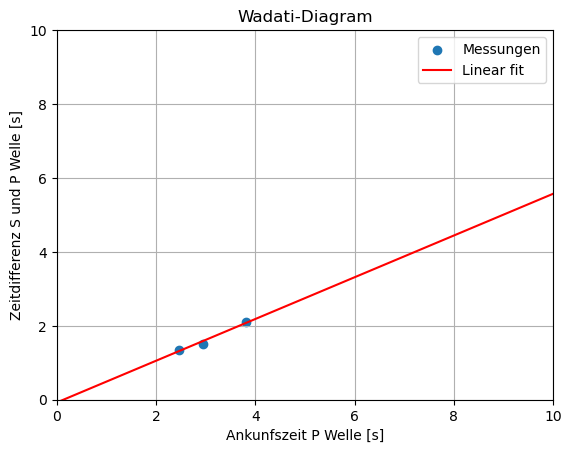

In [34]:
# Lösung
plt.close('all')
%matplotlib inline


p_times, sp_times = [], []
for ps in [selected_p_s_station1, selected_p_s_station2, selected_p_s_station3]:
    p = ps["P"]
    s = ps["S"]
    sp_times.append(ps["S"]-p)
    p_times.append(p)

plt.scatter(p_times, sp_times,label="Messungen")
plt.xlim(0,10)
plt.ylim(0,10)
plt.xlabel("Ankunfszeit P Welle [s]")
plt.ylabel("Zeitdifferenz S und P Welle [s]")
plt.title("Wadati-Diagram")

m, b = np.polyfit(p_times, sp_times, 1)
x = np.linspace(0,10,11)
y_fit = m * x + b

plt.plot(x, y_fit, color='red', label=f'Linear fit')
plt.legend()
plt.grid()